<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy"):
  for file in fileList:
    if(file not in exclusion):
      western_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
western_files = random.sample(western_files, 2008)

indian_files = []
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_numpy"):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files + western_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,PeekABoo.npy,PeekABoo.npy,Indian_numpy
1,NaJa.npy,NaJa.npy,Indian_numpy
2,Qismat.npy,Qismat.npy,Indian_numpy
3,INeedYa.npy,INeedYa.npy,Indian_numpy
4,KuriLagdi.npy,KuriLagdi.npy,Indian_numpy


In [ ]:
if class_level_loss_mode == "all":
  indian_dataDF = pd.DataFrame(indian_files, columns=['Images','songs','labels'])
  indian_dataDF.head()
elif class_level_loss_mode == "test":
  indian_dataDF = dataDF[dataDF['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [ ]:
if class_level_loss_mode == "all":
  western_dataDF = pd.DataFrame(western_files, columns=['Images','songs','labels'])
  western_dataDF.head()
elif class_level_loss_mode == "test":
  western_dataDF = dataDF[dataDF['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)

In [ ]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2008,2008
Western_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_numpy/PaniDaRangFemale.npy
75.97641


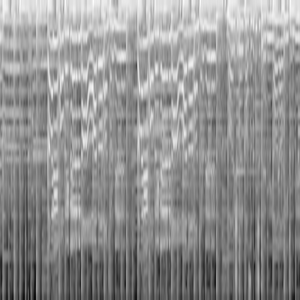

In [ ]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



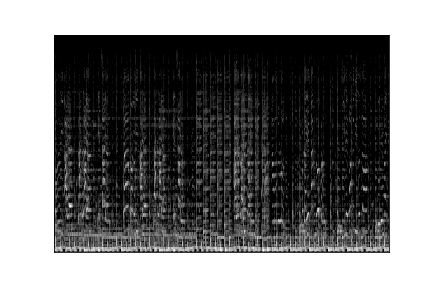

In [ ]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [ ]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,PeekABoo.npy,PeekABoo.npy,Indian_numpy,0
1,NaJa.npy,NaJa.npy,Indian_numpy,0
2,Qismat.npy,Qismat.npy,Indian_numpy,0
3,INeedYa.npy,INeedYa.npy,Indian_numpy,0
4,KuriLagdi.npy,KuriLagdi.npy,Indian_numpy,0


In [ ]:
indian_dataDF['encoded_labels'] = lb.transform(indian_dataDF['labels'])
western_dataDF['encoded_labels'] = lb.transform(western_dataDF['labels'])

In [ ]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008
Western_numpy,1,2008,2008


In [ ]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


if class_level_loss_mode == "test":
  western_dataDF = df_test[df_test['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)
  indian_dataDF = df_test[df_test['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [ ]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1405,1405
Western_numpy,1,1406,1406


In [ ]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603
Western_numpy,1,602,602


In [ ]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603


In [ ]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [ ]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return data, label



In [ ]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
western_dataset = MEL_Dataset(western_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)
western_loader = torch.utils.data.DataLoader(western_dataset, batch_size=batch_size)


In [ ]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

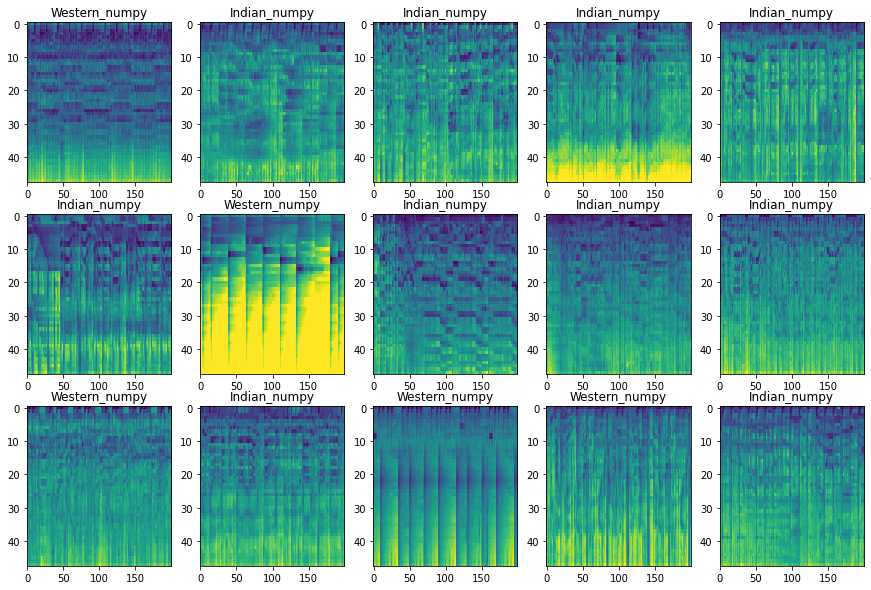

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

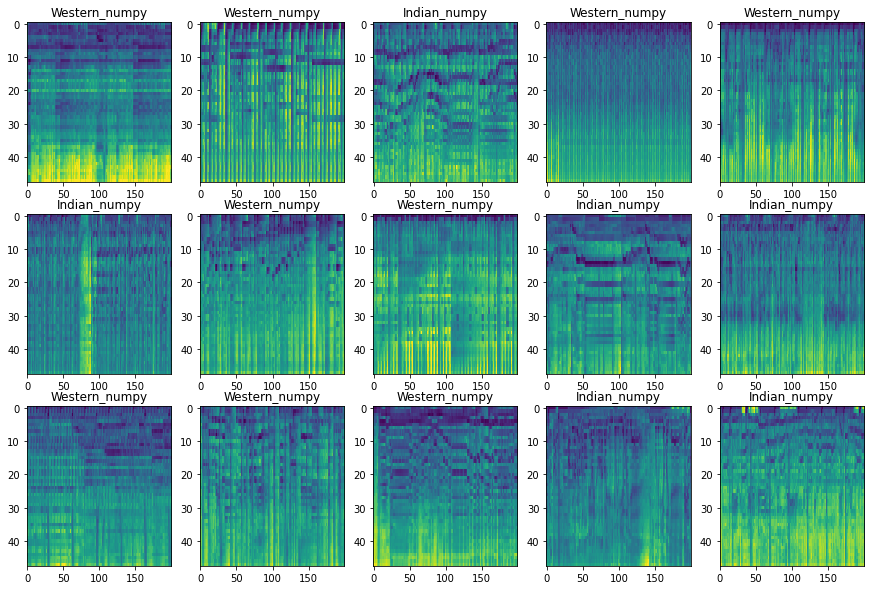

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

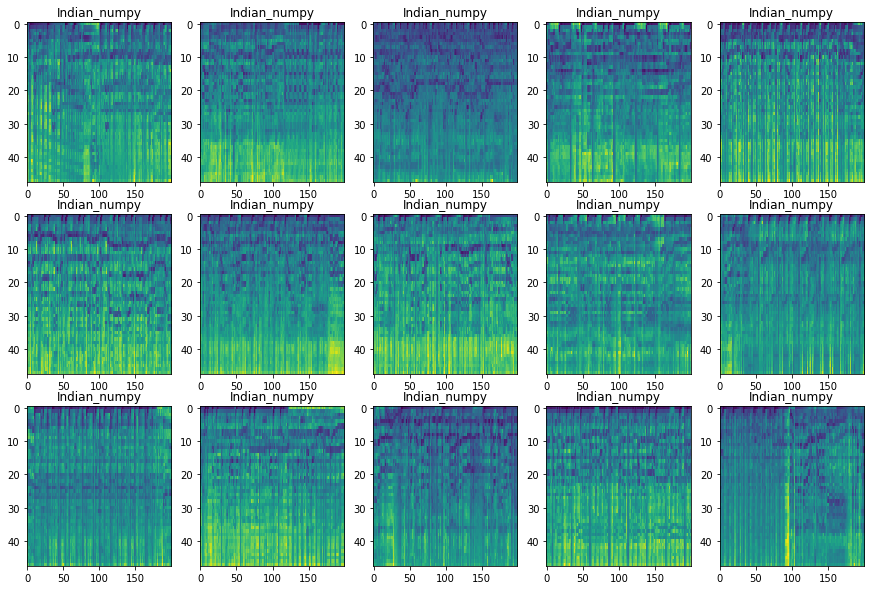

In [ ]:
# get some random training images
dataiter = iter(indian_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

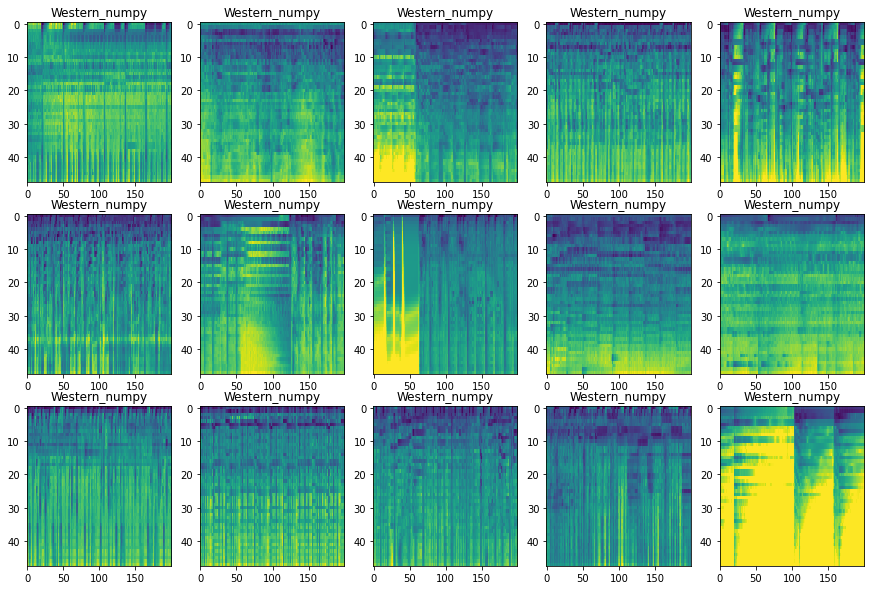

In [ ]:
# get some random training images
dataiter = iter(western_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1284.025
[1,     2] loss: 1411.677
[1,     3] loss: 1129.633
[1,     4] loss: 1072.833
[1,     5] loss: 1062.241
[1,     6] loss: 897.613
[1,     7] loss: 693.346
[1,     8] loss: 377.266
[1,     9] loss: 222.220
[1,    10] loss: 690.704
[1,    11] loss: 330.679
[1,    12] loss: 117.952
[1,    13] loss: 162.719
[1,    14] loss: 175.456
[1,    15] loss: 217.571
[1,    16] loss: 281.482
[1,    17] loss: 269.698
[1,    18] loss: 216.316
[1,    19] loss: 224.447
[1,    20] loss: 147.987
[1,    21] loss: 139.512
[1,    22] loss: 158.100
[1,    23] loss: 142.168
[1,    24] loss: 144.202
[1,    25] loss: 171.447
[1,    26] loss: 152.261
[1,    27] loss: 157.110
[1,    28] loss: 133.666
[1,    29] loss: 126.719
[1,    30] loss: 105.677
[1,    31] loss: 109.717
[1,    32] loss: 89.728
[1,    33] loss: 113.510
[1,    34] loss: 105.074
[1,    35] loss: 142.662
[1,    36] loss: 94.575
[1,    37] loss: 100.454
[1,    38] loss: 129.424
[1,    39] loss: 99.045
[1,    40] loss: 106.66

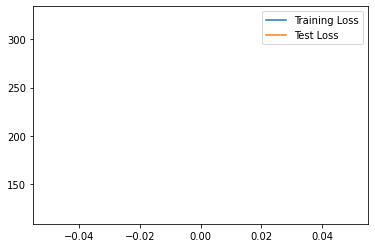

LOSS of the network on the test images: 845 %
Mean of the network on the Indian images after epoch 0 is 93.9513897365994
LOSS of the network on the test images: 1419 %
Mean of the network on the Western images after epoch 0 is 157.72677697075738


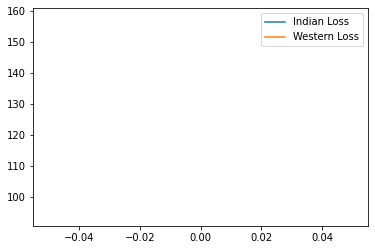

[2,     1] loss: 101.287
[2,     2] loss: 122.214
[2,     3] loss: 94.055
[2,     4] loss: 110.137
[2,     5] loss: 128.951
[2,     6] loss: 132.505
[2,     7] loss: 128.832
[2,     8] loss: 128.288
[2,     9] loss: 136.430
[2,    10] loss: 94.348
[2,    11] loss: 167.454
[2,    12] loss: 89.567
[2,    13] loss: 123.858
[2,    14] loss: 105.174
[2,    15] loss: 104.244
[2,    16] loss: 125.011
[2,    17] loss: 122.522
[2,    18] loss: 116.752
[2,    19] loss: 129.583
[2,    20] loss: 109.879
[2,    21] loss: 109.738
[2,    22] loss: 127.643
[2,    23] loss: 114.233
[2,    24] loss: 97.211
[2,    25] loss: 121.031
[2,    26] loss: 94.634
[2,    27] loss: 102.434
[2,    28] loss: 97.720
[2,    29] loss: 112.538
[2,    30] loss: 93.151
[2,    31] loss: 99.426
[2,    32] loss: 84.556
[2,    33] loss: 95.077
[2,    34] loss: 88.296
[2,    35] loss: 109.838
[2,    36] loss: 84.891
[2,    37] loss: 87.603
[2,    38] loss: 104.667
[2,    39] loss: 89.664
[2,    40] loss: 90.468
[2,    41] loss

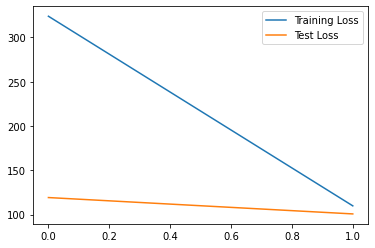

LOSS of the network on the test images: 689 %
Mean of the network on the Indian images after epoch 1 is 76.60996203952365
LOSS of the network on the test images: 1227 %
Mean of the network on the Western images after epoch 1 is 136.33931477864584


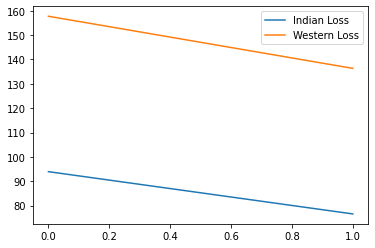

[3,     1] loss: 84.619
[3,     2] loss: 101.357
[3,     3] loss: 79.629
[3,     4] loss: 87.322
[3,     5] loss: 99.542
[3,     6] loss: 103.593
[3,     7] loss: 99.553
[3,     8] loss: 90.926
[3,     9] loss: 89.000
[3,    10] loss: 73.810
[3,    11] loss: 113.540
[3,    12] loss: 69.490
[3,    13] loss: 82.328
[3,    14] loss: 76.780
[3,    15] loss: 75.589
[3,    16] loss: 78.541
[3,    17] loss: 78.282
[3,    18] loss: 78.850
[3,    19] loss: 80.264
[3,    20] loss: 78.987
[3,    21] loss: 74.810
[3,    22] loss: 75.107
[3,    23] loss: 74.618
[3,    24] loss: 74.685
[3,    25] loss: 73.095
[3,    26] loss: 73.071
[3,    27] loss: 72.711
[3,    28] loss: 72.523
[3,    29] loss: 75.008
[3,    30] loss: 65.913
[3,    31] loss: 76.793
[3,    32] loss: 62.275
[3,    33] loss: 68.444
[3,    34] loss: 70.345
[3,    35] loss: 72.355
[3,    36] loss: 64.144
[3,    37] loss: 71.135
[3,    38] loss: 75.384
[3,    39] loss: 68.374
[3,    40] loss: 66.677
[3,    41] loss: 70.256
[3,    42] lo

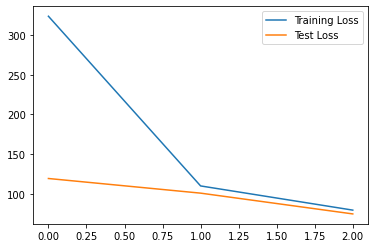

LOSS of the network on the test images: 615 %
Mean of the network on the Indian images after epoch 2 is 68.34672376844618
LOSS of the network on the test images: 804 %
Mean of the network on the Western images after epoch 2 is 89.37073855929904


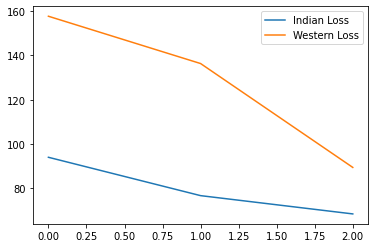

[4,     1] loss: 68.941
[4,     2] loss: 72.837
[4,     3] loss: 66.183
[4,     4] loss: 64.611
[4,     5] loss: 72.321
[4,     6] loss: 77.970
[4,     7] loss: 82.640
[4,     8] loss: 70.670
[4,     9] loss: 73.633
[4,    10] loss: 65.478
[4,    11] loss: 86.686
[4,    12] loss: 66.229
[4,    13] loss: 75.435
[4,    14] loss: 75.052
[4,    15] loss: 70.184
[4,    16] loss: 72.326
[4,    17] loss: 75.540
[4,    18] loss: 71.535
[4,    19] loss: 76.663
[4,    20] loss: 75.707
[4,    21] loss: 71.895
[4,    22] loss: 71.274
[4,    23] loss: 73.072
[4,    24] loss: 70.130
[4,    25] loss: 70.620
[4,    26] loss: 71.338
[4,    27] loss: 71.618
[4,    28] loss: 70.037
[4,    29] loss: 74.087
[4,    30] loss: 64.528
[4,    31] loss: 74.720
[4,    32] loss: 61.247
[4,    33] loss: 67.149
[4,    34] loss: 69.891
[4,    35] loss: 70.809
[4,    36] loss: 64.180
[4,    37] loss: 70.283
[4,    38] loss: 74.542
[4,    39] loss: 68.030
[4,    40] loss: 65.703
[4,    41] loss: 69.731
[4,    42] loss:

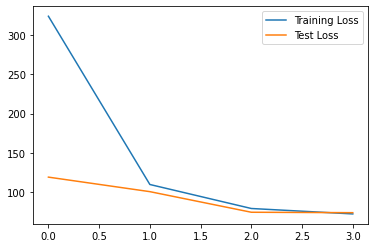

LOSS of the network on the test images: 611 %
Mean of the network on the Indian images after epoch 3 is 67.93604999118381
LOSS of the network on the test images: 797 %
Mean of the network on the Western images after epoch 3 is 88.61266665988498


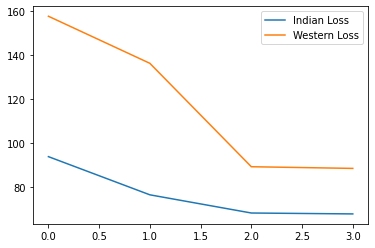

[5,     1] loss: 68.447
[5,     2] loss: 71.181
[5,     3] loss: 65.868
[5,     4] loss: 63.631
[5,     5] loss: 71.944
[5,     6] loss: 76.933
[5,     7] loss: 81.578
[5,     8] loss: 69.817
[5,     9] loss: 73.051
[5,    10] loss: 65.086
[5,    11] loss: 85.341
[5,    12] loss: 66.012
[5,    13] loss: 74.908
[5,    14] loss: 74.702
[5,    15] loss: 69.734
[5,    16] loss: 71.762
[5,    17] loss: 75.133
[5,    18] loss: 71.067
[5,    19] loss: 76.244
[5,    20] loss: 75.510
[5,    21] loss: 71.559
[5,    22] loss: 70.887
[5,    23] loss: 72.141
[5,    24] loss: 70.283
[5,    25] loss: 70.139
[5,    26] loss: 71.259
[5,    27] loss: 71.109
[5,    28] loss: 69.927
[5,    29] loss: 73.442
[5,    30] loss: 64.414
[5,    31] loss: 74.134
[5,    32] loss: 61.285
[5,    33] loss: 66.629
[5,    34] loss: 69.760
[5,    35] loss: 70.167
[5,    36] loss: 64.151
[5,    37] loss: 69.893
[5,    38] loss: 74.421
[5,    39] loss: 67.825
[5,    40] loss: 65.420
[5,    41] loss: 69.277
[5,    42] loss:

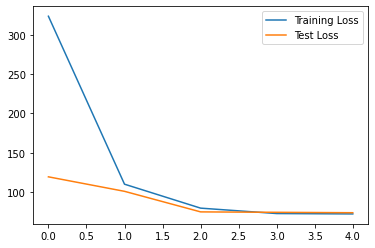

LOSS of the network on the test images: 608 %
Mean of the network on the Indian images after epoch 4 is 67.65430280897353
LOSS of the network on the test images: 790 %
Mean of the network on the Western images after epoch 4 is 87.8241195678711


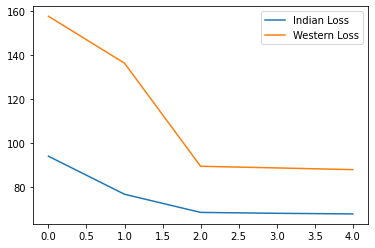

[6,     1] loss: 68.139
[6,     2] loss: 70.440
[6,     3] loss: 65.473
[6,     4] loss: 63.073
[6,     5] loss: 71.402
[6,     6] loss: 76.405
[6,     7] loss: 80.875
[6,     8] loss: 69.159
[6,     9] loss: 72.470
[6,    10] loss: 64.908
[6,    11] loss: 84.338
[6,    12] loss: 66.589
[6,    13] loss: 74.396
[6,    14] loss: 74.943
[6,    15] loss: 69.436
[6,    16] loss: 71.974
[6,    17] loss: 74.763
[6,    18] loss: 70.858
[6,    19] loss: 75.580
[6,    20] loss: 75.500
[6,    21] loss: 71.129
[6,    22] loss: 70.693
[6,    23] loss: 71.202
[6,    24] loss: 70.201
[6,    25] loss: 69.937
[6,    26] loss: 71.013
[6,    27] loss: 70.864
[6,    28] loss: 69.564
[6,    29] loss: 73.138
[6,    30] loss: 63.916
[6,    31] loss: 73.875
[6,    32] loss: 60.802
[6,    33] loss: 66.388
[6,    34] loss: 69.218
[6,    35] loss: 69.814
[6,    36] loss: 63.575
[6,    37] loss: 69.723
[6,    38] loss: 73.865
[6,    39] loss: 67.768
[6,    40] loss: 65.049
[6,    41] loss: 69.049
[6,    42] loss:

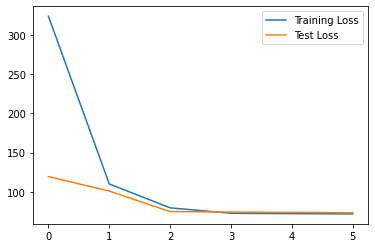

LOSS of the network on the test images: 607 %
Mean of the network on the Indian images after epoch 5 is 67.50054041544597
LOSS of the network on the test images: 785 %
Mean of the network on the Western images after epoch 5 is 87.25006951226129


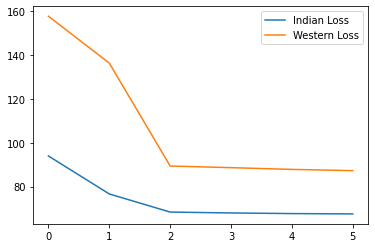

[7,     1] loss: 67.953
[7,     2] loss: 69.911
[7,     3] loss: 65.197
[7,     4] loss: 62.752
[7,     5] loss: 70.897
[7,     6] loss: 75.931
[7,     7] loss: 80.186
[7,     8] loss: 68.660
[7,     9] loss: 71.860
[7,    10] loss: 64.601
[7,    11] loss: 83.276
[7,    12] loss: 66.094
[7,    13] loss: 73.958
[7,    14] loss: 74.299
[7,    15] loss: 69.221
[7,    16] loss: 71.526
[7,    17] loss: 74.456
[7,    18] loss: 70.189
[7,    19] loss: 75.091
[7,    20] loss: 74.923
[7,    21] loss: 70.865
[7,    22] loss: 70.154
[7,    23] loss: 70.735
[7,    24] loss: 69.546
[7,    25] loss: 69.658
[7,    26] loss: 70.412
[7,    27] loss: 70.523
[7,    28] loss: 68.937
[7,    29] loss: 72.792
[7,    30] loss: 63.231
[7,    31] loss: 73.626
[7,    32] loss: 60.222
[7,    33] loss: 66.083
[7,    34] loss: 68.595
[7,    35] loss: 69.468
[7,    36] loss: 62.917
[7,    37] loss: 69.525
[7,    38] loss: 73.191
[7,    39] loss: 67.552
[7,    40] loss: 64.657
[7,    41] loss: 68.734
[7,    42] loss:

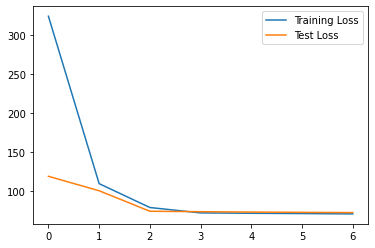

LOSS of the network on the test images: 606 %
Mean of the network on the Indian images after epoch 6 is 67.36677805582683
LOSS of the network on the test images: 780 %
Mean of the network on the Western images after epoch 6 is 86.74806806776259


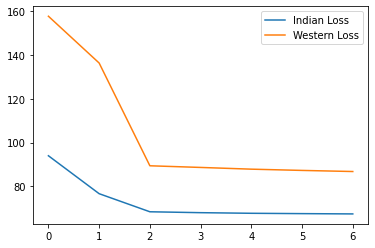

[8,     1] loss: 67.754
[8,     2] loss: 69.446
[8,     3] loss: 64.950
[8,     4] loss: 62.446
[8,     5] loss: 70.493
[8,     6] loss: 75.370
[8,     7] loss: 79.457
[8,     8] loss: 68.190
[8,     9] loss: 71.319
[8,    10] loss: 64.259
[8,    11] loss: 82.385
[8,    12] loss: 65.502
[8,    13] loss: 73.536
[8,    14] loss: 73.639
[8,    15] loss: 69.021
[8,    16] loss: 71.077
[8,    17] loss: 74.178
[8,    18] loss: 69.430
[8,    19] loss: 74.661
[8,    20] loss: 74.274
[8,    21] loss: 70.651
[8,    22] loss: 69.637
[8,    23] loss: 70.350
[8,    24] loss: 68.832
[8,    25] loss: 69.290
[8,    26] loss: 69.783
[8,    27] loss: 70.062
[8,    28] loss: 68.340
[8,    29] loss: 72.340
[8,    30] loss: 62.582
[8,    31] loss: 73.256
[8,    32] loss: 59.784
[8,    33] loss: 65.591
[8,    34] loss: 68.142
[8,    35] loss: 68.905
[8,    36] loss: 62.560
[8,    37] loss: 69.002
[8,    38] loss: 72.927
[8,    39] loss: 66.863
[8,    40] loss: 64.628
[8,    41] loss: 68.224
[8,    42] loss:

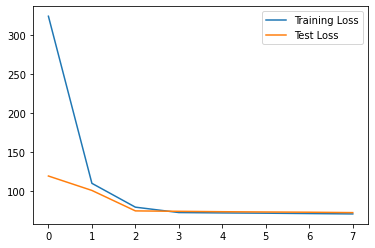

LOSS of the network on the test images: 603 %
Mean of the network on the Indian images after epoch 7 is 67.00325308905707
LOSS of the network on the test images: 774 %
Mean of the network on the Western images after epoch 7 is 86.06783633761935


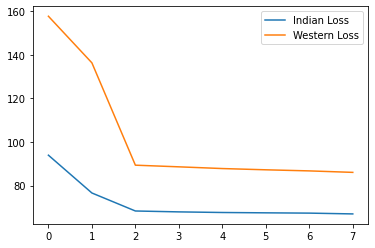

[9,     1] loss: 67.280
[9,     2] loss: 69.103
[9,     3] loss: 64.864
[9,     4] loss: 62.208
[9,     5] loss: 70.398
[9,     6] loss: 74.835
[9,     7] loss: 78.728
[9,     8] loss: 67.596
[9,     9] loss: 70.939
[9,    10] loss: 64.019
[9,    11] loss: 81.858
[9,    12] loss: 66.194
[9,    13] loss: 73.063
[9,    14] loss: 73.903
[9,    15] loss: 68.970
[9,    16] loss: 71.148
[9,    17] loss: 74.508
[9,    18] loss: 68.699
[9,    19] loss: 74.703
[9,    20] loss: 73.752
[9,    21] loss: 70.714
[9,    22] loss: 69.407
[9,    23] loss: 70.113
[9,    24] loss: 68.358
[9,    25] loss: 68.901
[9,    26] loss: 69.384
[9,    27] loss: 69.539
[9,    28] loss: 67.956
[9,    29] loss: 71.815
[9,    30] loss: 62.072
[9,    31] loss: 72.759
[9,    32] loss: 59.557
[9,    33] loss: 64.958
[9,    34] loss: 67.688
[9,    35] loss: 68.226
[9,    36] loss: 62.184
[9,    37] loss: 68.390
[9,    38] loss: 72.467
[9,    39] loss: 66.423
[9,    40] loss: 64.211
[9,    41] loss: 67.901
[9,    42] loss:

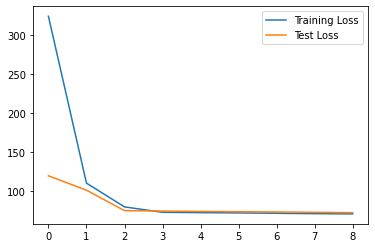

LOSS of the network on the test images: 600 %
Mean of the network on the Indian images after epoch 8 is 66.77050526936848
LOSS of the network on the test images: 769 %
Mean of the network on the Western images after epoch 8 is 85.48304918077257


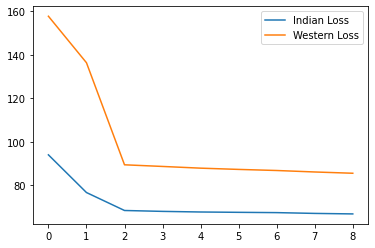

[10,     1] loss: 66.879
[10,     2] loss: 68.403
[10,     3] loss: 64.592
[10,     4] loss: 61.805
[10,     5] loss: 69.998
[10,     6] loss: 74.165
[10,     7] loss: 77.865
[10,     8] loss: 66.966
[10,     9] loss: 70.158
[10,    10] loss: 63.571
[10,    11] loss: 80.821
[10,    12] loss: 65.739
[10,    13] loss: 72.434
[10,    14] loss: 73.149
[10,    15] loss: 68.723
[10,    16] loss: 70.526
[10,    17] loss: 74.028
[10,    18] loss: 67.753
[10,    19] loss: 74.065
[10,    20] loss: 73.297
[10,    21] loss: 70.072
[10,    22] loss: 69.199
[10,    23] loss: 69.608
[10,    24] loss: 67.937
[10,    25] loss: 68.089
[10,    26] loss: 68.875
[10,    27] loss: 68.843
[10,    28] loss: 67.420
[10,    29] loss: 71.241
[10,    30] loss: 61.356
[10,    31] loss: 72.061
[10,    32] loss: 59.108
[10,    33] loss: 64.184
[10,    34] loss: 66.763
[10,    35] loss: 67.326
[10,    36] loss: 61.475
[10,    37] loss: 67.651
[10,    38] loss: 71.546
[10,    39] loss: 65.845
[10,    40] loss: 63.450


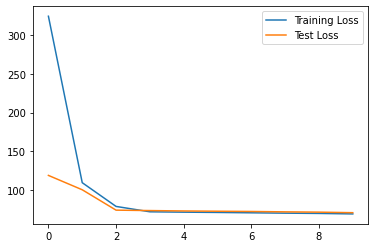

LOSS of the network on the test images: 597 %
Mean of the network on the Indian images after epoch 9 is 66.3745346069336
LOSS of the network on the test images: 760 %
Mean of the network on the Western images after epoch 9 is 84.45371331108942


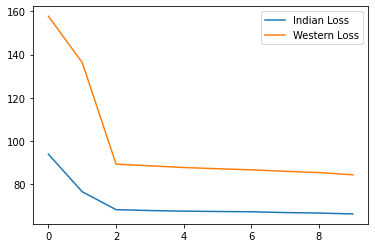

[11,     1] loss: 66.120
[11,     2] loss: 67.378
[11,     3] loss: 63.855
[11,     4] loss: 61.323
[11,     5] loss: 69.006
[11,     6] loss: 73.329
[11,     7] loss: 76.541
[11,     8] loss: 65.910
[11,     9] loss: 69.005
[11,    10] loss: 62.700
[11,    11] loss: 78.612
[11,    12] loss: 63.992
[11,    13] loss: 71.256
[11,    14] loss: 70.892
[11,    15] loss: 67.924
[11,    16] loss: 69.406
[11,    17] loss: 71.582
[11,    18] loss: 66.125
[11,    19] loss: 72.390
[11,    20] loss: 72.147
[11,    21] loss: 68.018
[11,    22] loss: 67.823
[11,    23] loss: 68.545
[11,    24] loss: 66.757
[11,    25] loss: 66.517
[11,    26] loss: 67.508
[11,    27] loss: 68.371
[11,    28] loss: 66.884
[11,    29] loss: 70.102
[11,    30] loss: 59.512
[11,    31] loss: 70.111
[11,    32] loss: 57.689
[11,    33] loss: 62.126
[11,    34] loss: 64.041
[11,    35] loss: 64.783
[11,    36] loss: 59.679
[11,    37] loss: 65.441
[11,    38] loss: 68.362
[11,    39] loss: 63.906
[11,    40] loss: 61.000


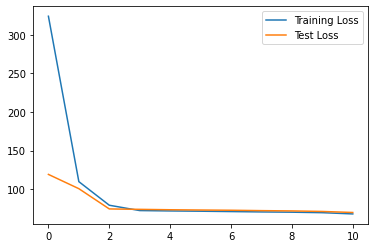

LOSS of the network on the test images: 595 %
Mean of the network on the Indian images after epoch 10 is 66.17217042711046
LOSS of the network on the test images: 736 %
Mean of the network on the Western images after epoch 10 is 81.80695088704427


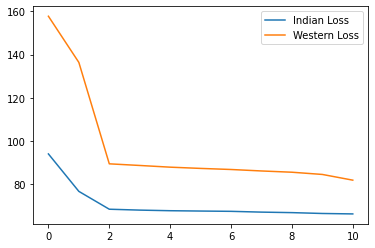

[12,     1] loss: 64.618
[12,     2] loss: 67.484
[12,     3] loss: 62.177
[12,     4] loss: 59.018
[12,     5] loss: 67.471
[12,     6] loss: 72.217
[12,     7] loss: 74.151
[12,     8] loss: 61.613
[12,     9] loss: 63.838
[12,    10] loss: 63.202
[12,    11] loss: 73.524
[12,    12] loss: 63.465
[12,    13] loss: 71.650
[12,    14] loss: 65.855
[12,    15] loss: 66.028
[12,    16] loss: 68.774
[12,    17] loss: 65.778
[12,    18] loss: 61.954
[12,    19] loss: 67.979
[12,    20] loss: 67.154
[12,    21] loss: 62.988
[12,    22] loss: 64.198
[12,    23] loss: 67.273
[12,    24] loss: 61.039
[12,    25] loss: 61.956
[12,    26] loss: 63.654
[12,    27] loss: 65.077
[12,    28] loss: 61.379
[12,    29] loss: 66.905
[12,    30] loss: 54.180
[12,    31] loss: 64.092
[12,    32] loss: 54.009
[12,    33] loss: 56.047
[12,    34] loss: 58.590
[12,    35] loss: 58.562
[12,    36] loss: 56.031
[12,    37] loss: 61.888
[12,    38] loss: 62.059
[12,    39] loss: 60.327
[12,    40] loss: 57.051


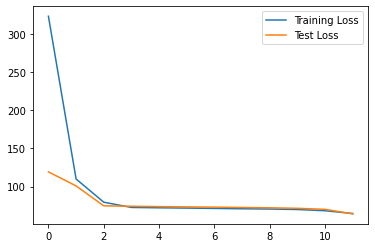

LOSS of the network on the test images: 556 %
Mean of the network on the Indian images after epoch 11 is 61.87624274359809
LOSS of the network on the test images: 659 %
Mean of the network on the Western images after epoch 11 is 73.28005684746637


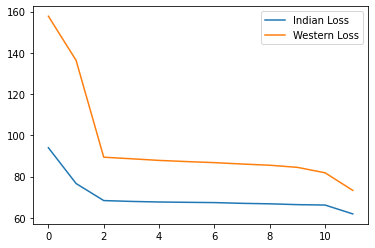

[13,     1] loss: 58.643
[13,     2] loss: 60.878
[13,     3] loss: 55.555
[13,     4] loss: 56.575
[13,     5] loss: 60.143
[13,     6] loss: 63.385
[13,     7] loss: 67.346
[13,     8] loss: 57.904
[13,     9] loss: 57.619
[13,    10] loss: 56.028
[13,    11] loss: 67.946
[13,    12] loss: 60.278
[13,    13] loss: 61.660
[13,    14] loss: 62.252
[13,    15] loss: 59.987
[13,    16] loss: 63.088
[13,    17] loss: 62.786
[13,    18] loss: 56.384
[13,    19] loss: 62.914
[13,    20] loss: 65.031
[13,    21] loss: 59.374
[13,    22] loss: 61.927
[13,    23] loss: 63.392
[13,    24] loss: 60.099
[13,    25] loss: 58.500
[13,    26] loss: 62.065
[13,    27] loss: 62.098
[13,    28] loss: 59.165
[13,    29] loss: 63.742
[13,    30] loss: 52.249
[13,    31] loss: 61.408
[13,    32] loss: 52.351
[13,    33] loss: 54.045
[13,    34] loss: 56.109
[13,    35] loss: 56.571
[13,    36] loss: 53.432
[13,    37] loss: 59.105
[13,    38] loss: 59.540
[13,    39] loss: 58.129
[13,    40] loss: 54.608


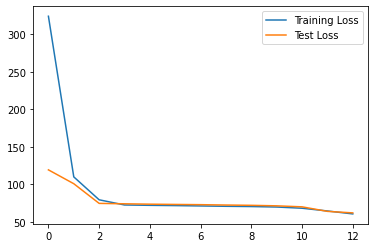

LOSS of the network on the test images: 544 %
Mean of the network on the Indian images after epoch 12 is 60.505763583713104
LOSS of the network on the test images: 633 %
Mean of the network on the Western images after epoch 12 is 70.35884348551433


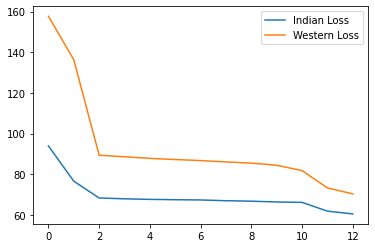

[14,     1] loss: 56.546
[14,     2] loss: 58.503
[14,     3] loss: 53.828
[14,     4] loss: 54.869
[14,     5] loss: 58.100
[14,     6] loss: 60.915
[14,     7] loss: 64.186
[14,     8] loss: 55.431
[14,     9] loss: 55.599
[14,    10] loss: 54.460
[14,    11] loss: 62.891
[14,    12] loss: 57.945
[14,    13] loss: 59.026
[14,    14] loss: 59.204
[14,    15] loss: 57.998
[14,    16] loss: 59.244
[14,    17] loss: 61.805
[14,    18] loss: 52.925
[14,    19] loss: 60.866
[14,    20] loss: 62.028
[14,    21] loss: 57.103
[14,    22] loss: 59.681
[14,    23] loss: 60.718
[14,    24] loss: 57.583
[14,    25] loss: 55.879
[14,    26] loss: 59.875
[14,    27] loss: 60.238
[14,    28] loss: 56.905
[14,    29] loss: 62.592
[14,    30] loss: 50.277
[14,    31] loss: 59.852
[14,    32] loss: 50.709
[14,    33] loss: 52.487
[14,    34] loss: 54.135
[14,    35] loss: 55.057
[14,    36] loss: 51.839
[14,    37] loss: 56.006
[14,    38] loss: 57.681
[14,    39] loss: 56.175
[14,    40] loss: 52.943


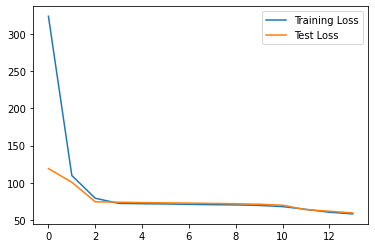

LOSS of the network on the test images: 526 %
Mean of the network on the Indian images after epoch 13 is 58.48995717366537
LOSS of the network on the test images: 606 %
Mean of the network on the Western images after epoch 13 is 67.42495176527235


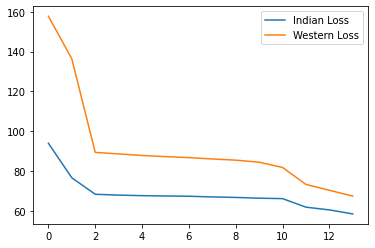

[15,     1] loss: 54.344
[15,     2] loss: 57.327
[15,     3] loss: 51.307
[15,     4] loss: 53.478
[15,     5] loss: 56.707
[15,     6] loss: 58.470
[15,     7] loss: 60.829
[15,     8] loss: 53.615
[15,     9] loss: 53.525
[15,    10] loss: 52.604
[15,    11] loss: 59.888
[15,    12] loss: 57.792
[15,    13] loss: 56.384
[15,    14] loss: 57.793
[15,    15] loss: 56.093
[15,    16] loss: 56.842
[15,    17] loss: 60.650
[15,    18] loss: 50.901
[15,    19] loss: 58.964
[15,    20] loss: 60.203
[15,    21] loss: 54.717
[15,    22] loss: 58.056
[15,    23] loss: 59.171
[15,    24] loss: 55.375
[15,    25] loss: 53.537
[15,    26] loss: 57.940
[15,    27] loss: 57.544
[15,    28] loss: 55.498
[15,    29] loss: 59.777
[15,    30] loss: 48.940
[15,    31] loss: 57.724
[15,    32] loss: 49.371
[15,    33] loss: 51.336
[15,    34] loss: 51.595
[15,    35] loss: 53.860
[15,    36] loss: 50.145
[15,    37] loss: 53.979
[15,    38] loss: 56.103
[15,    39] loss: 54.709
[15,    40] loss: 51.717


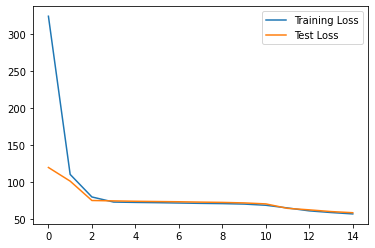

LOSS of the network on the test images: 516 %
Mean of the network on the Indian images after epoch 14 is 57.43319405449761
LOSS of the network on the test images: 586 %
Mean of the network on the Western images after epoch 14 is 65.14961539374457


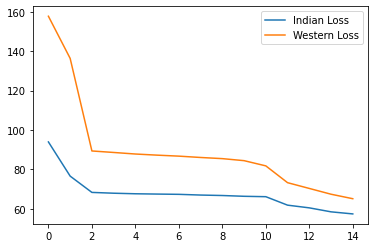

[16,     1] loss: 52.914
[16,     2] loss: 55.906
[16,     3] loss: 49.478
[16,     4] loss: 52.284
[16,     5] loss: 55.223
[16,     6] loss: 56.509
[16,     7] loss: 58.529
[16,     8] loss: 52.064
[16,     9] loss: 51.888
[16,    10] loss: 51.316
[16,    11] loss: 57.168
[16,    12] loss: 55.916
[16,    13] loss: 54.631
[16,    14] loss: 55.851
[16,    15] loss: 54.391
[16,    16] loss: 55.019
[16,    17] loss: 57.696
[16,    18] loss: 50.175
[16,    19] loss: 56.818
[16,    20] loss: 58.739
[16,    21] loss: 52.864
[16,    22] loss: 56.035
[16,    23] loss: 57.582
[16,    24] loss: 54.187
[16,    25] loss: 52.220
[16,    26] loss: 55.938
[16,    27] loss: 56.279
[16,    28] loss: 53.588
[16,    29] loss: 57.938
[16,    30] loss: 47.541
[16,    31] loss: 55.761
[16,    32] loss: 48.497
[16,    33] loss: 49.698
[16,    34] loss: 50.238
[16,    35] loss: 52.457
[16,    36] loss: 48.872
[16,    37] loss: 52.771
[16,    38] loss: 54.655
[16,    39] loss: 53.449
[16,    40] loss: 50.829


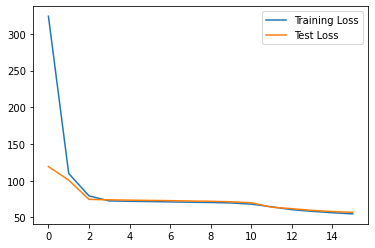

LOSS of the network on the test images: 509 %
Mean of the network on the Indian images after epoch 15 is 56.665614657931854
LOSS of the network on the test images: 572 %
Mean of the network on the Western images after epoch 15 is 63.611900329589844


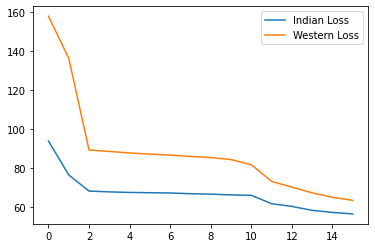

[17,     1] loss: 51.824
[17,     2] loss: 54.506
[17,     3] loss: 48.389
[17,     4] loss: 50.946
[17,     5] loss: 54.212
[17,     6] loss: 54.643
[17,     7] loss: 56.690
[17,     8] loss: 50.785
[17,     9] loss: 50.941
[17,    10] loss: 50.368
[17,    11] loss: 55.535
[17,    12] loss: 53.889
[17,    13] loss: 53.129
[17,    14] loss: 54.457
[17,    15] loss: 52.411
[17,    16] loss: 53.728
[17,    17] loss: 55.518
[17,    18] loss: 48.677
[17,    19] loss: 55.706
[17,    20] loss: 57.772
[17,    21] loss: 51.687
[17,    22] loss: 54.894
[17,    23] loss: 56.224
[17,    24] loss: 53.259
[17,    25] loss: 51.582
[17,    26] loss: 54.820
[17,    27] loss: 55.021
[17,    28] loss: 52.854
[17,    29] loss: 56.208
[17,    30] loss: 46.750
[17,    31] loss: 54.442
[17,    32] loss: 47.574
[17,    33] loss: 48.723
[17,    34] loss: 49.020
[17,    35] loss: 51.238
[17,    36] loss: 47.859
[17,    37] loss: 51.898
[17,    38] loss: 53.416
[17,    39] loss: 52.369
[17,    40] loss: 49.817


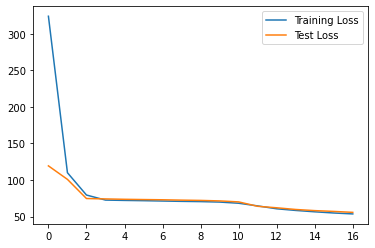

LOSS of the network on the test images: 502 %
Mean of the network on the Indian images after epoch 16 is 55.80615573459201
LOSS of the network on the test images: 555 %
Mean of the network on the Western images after epoch 16 is 61.716973622639976


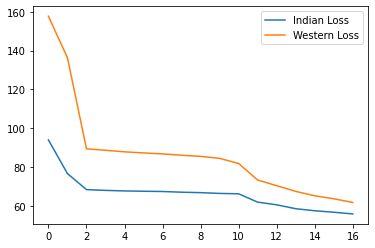

[18,     1] loss: 50.475
[18,     2] loss: 53.434
[18,     3] loss: 47.148
[18,     4] loss: 49.983
[18,     5] loss: 53.247
[18,     6] loss: 52.899
[18,     7] loss: 55.212
[18,     8] loss: 49.584
[18,     9] loss: 49.969
[18,    10] loss: 49.364
[18,    11] loss: 54.606
[18,    12] loss: 52.678
[18,    13] loss: 52.238
[18,    14] loss: 53.336
[18,    15] loss: 51.340
[18,    16] loss: 52.322
[18,    17] loss: 54.427
[18,    18] loss: 48.237
[18,    19] loss: 55.128
[18,    20] loss: 56.675
[18,    21] loss: 50.599
[18,    22] loss: 53.807
[18,    23] loss: 55.177
[18,    24] loss: 52.385
[18,    25] loss: 50.696
[18,    26] loss: 53.928
[18,    27] loss: 53.731
[18,    28] loss: 52.077
[18,    29] loss: 54.854
[18,    30] loss: 45.775
[18,    31] loss: 53.327
[18,    32] loss: 46.766
[18,    33] loss: 47.945
[18,    34] loss: 48.082
[18,    35] loss: 50.267
[18,    36] loss: 47.033
[18,    37] loss: 51.132
[18,    38] loss: 52.484
[18,    39] loss: 51.347
[18,    40] loss: 49.297


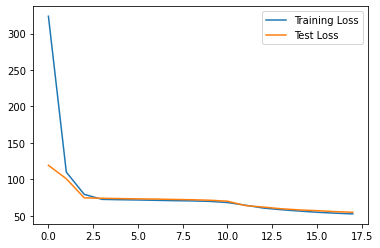

LOSS of the network on the test images: 496 %
Mean of the network on the Indian images after epoch 17 is 55.198646545410156
LOSS of the network on the test images: 544 %
Mean of the network on the Western images after epoch 17 is 60.49381764729818


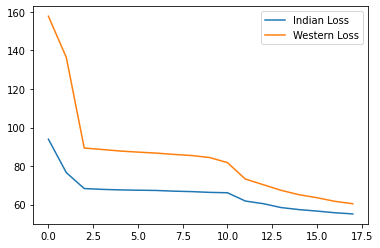

[19,     1] loss: 49.379
[19,     2] loss: 52.425
[19,     3] loss: 46.187
[19,     4] loss: 48.994
[19,     5] loss: 52.123
[19,     6] loss: 51.496
[19,     7] loss: 53.758
[19,     8] loss: 48.227
[19,     9] loss: 48.770
[19,    10] loss: 48.735
[19,    11] loss: 53.214
[19,    12] loss: 51.593
[19,    13] loss: 51.263
[19,    14] loss: 53.152
[19,    15] loss: 50.512
[19,    16] loss: 50.883
[19,    17] loss: 53.621
[19,    18] loss: 48.304
[19,    19] loss: 54.302
[19,    20] loss: 55.427
[19,    21] loss: 49.916
[19,    22] loss: 52.984
[19,    23] loss: 53.948
[19,    24] loss: 52.291
[19,    25] loss: 50.177
[19,    26] loss: 52.726
[19,    27] loss: 53.516
[19,    28] loss: 50.992
[19,    29] loss: 54.115
[19,    30] loss: 45.725
[19,    31] loss: 52.112
[19,    32] loss: 46.805
[19,    33] loss: 47.418
[19,    34] loss: 47.411
[19,    35] loss: 49.758
[19,    36] loss: 46.358
[19,    37] loss: 50.403
[19,    38] loss: 51.705
[19,    39] loss: 50.461
[19,    40] loss: 48.725


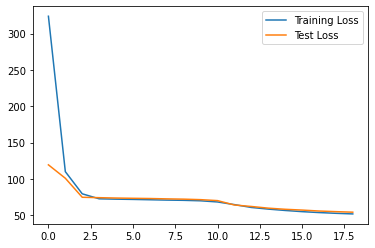

LOSS of the network on the test images: 492 %
Mean of the network on the Indian images after epoch 18 is 54.68315633138021
LOSS of the network on the test images: 534 %
Mean of the network on the Western images after epoch 18 is 59.42354965209961


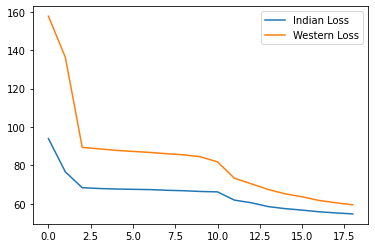

[20,     1] loss: 48.413
[20,     2] loss: 51.391
[20,     3] loss: 45.482
[20,     4] loss: 48.167
[20,     5] loss: 51.312
[20,     6] loss: 50.414
[20,     7] loss: 52.417
[20,     8] loss: 47.503
[20,     9] loss: 48.107
[20,    10] loss: 47.484
[20,    11] loss: 52.134
[20,    12] loss: 51.308
[20,    13] loss: 49.722
[20,    14] loss: 51.564
[20,    15] loss: 49.742
[20,    16] loss: 49.634
[20,    17] loss: 51.755
[20,    18] loss: 45.985
[20,    19] loss: 52.577
[20,    20] loss: 55.713
[20,    21] loss: 48.699
[20,    22] loss: 51.877
[20,    23] loss: 53.570
[20,    24] loss: 50.216
[20,    25] loss: 48.635
[20,    26] loss: 51.885
[20,    27] loss: 51.455
[20,    28] loss: 50.027
[20,    29] loss: 52.376
[20,    30] loss: 44.211
[20,    31] loss: 50.892
[20,    32] loss: 45.605
[20,    33] loss: 46.265
[20,    34] loss: 46.444
[20,    35] loss: 48.265
[20,    36] loss: 45.622
[20,    37] loss: 49.589
[20,    38] loss: 50.505
[20,    39] loss: 49.509
[20,    40] loss: 47.704


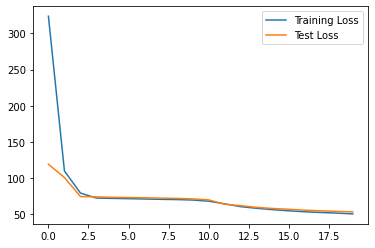

LOSS of the network on the test images: 486 %
Mean of the network on the Indian images after epoch 19 is 54.07443957858615
LOSS of the network on the test images: 526 %
Mean of the network on the Western images after epoch 19 is 58.4832394917806


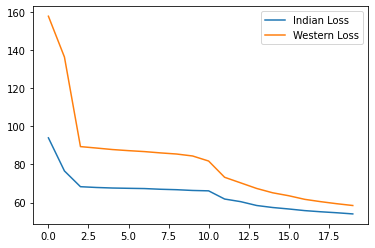

[21,     1] loss: 47.427
[21,     2] loss: 50.407
[21,     3] loss: 44.590
[21,     4] loss: 47.254
[21,     5] loss: 50.348
[21,     6] loss: 49.255
[21,     7] loss: 51.295
[21,     8] loss: 46.517
[21,     9] loss: 47.074
[21,    10] loss: 46.466
[21,    11] loss: 51.418
[21,    12] loss: 50.594
[21,    13] loss: 49.041
[21,    14] loss: 50.526
[21,    15] loss: 49.257
[21,    16] loss: 48.386
[21,    17] loss: 51.001
[21,    18] loss: 45.155
[21,    19] loss: 51.929
[21,    20] loss: 54.626
[21,    21] loss: 47.973
[21,    22] loss: 51.230
[21,    23] loss: 53.063
[21,    24] loss: 49.354
[21,    25] loss: 47.927
[21,    26] loss: 50.877
[21,    27] loss: 50.649
[21,    28] loss: 49.532
[21,    29] loss: 51.435
[21,    30] loss: 43.795
[21,    31] loss: 49.904
[21,    32] loss: 45.062
[21,    33] loss: 45.874
[21,    34] loss: 45.545
[21,    35] loss: 47.555
[21,    36] loss: 45.100
[21,    37] loss: 48.848
[21,    38] loss: 49.939
[21,    39] loss: 48.612
[21,    40] loss: 47.268


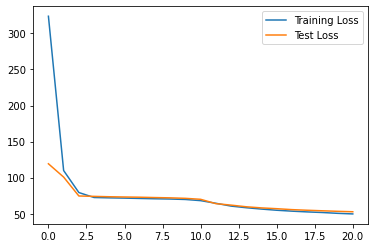

LOSS of the network on the test images: 482 %
Mean of the network on the Indian images after epoch 20 is 53.626261393229164
LOSS of the network on the test images: 518 %
Mean of the network on the Western images after epoch 20 is 57.64100562201606


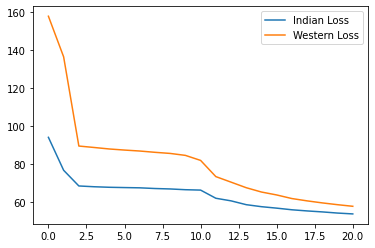

[22,     1] loss: 46.642
[22,     2] loss: 49.344
[22,     3] loss: 43.894
[22,     4] loss: 46.358
[22,     5] loss: 49.440
[22,     6] loss: 48.222
[22,     7] loss: 49.937
[22,     8] loss: 45.787
[22,     9] loss: 45.773
[22,    10] loss: 45.664
[22,    11] loss: 49.904
[22,    12] loss: 49.306
[22,    13] loss: 48.082
[22,    14] loss: 49.728
[22,    15] loss: 47.870
[22,    16] loss: 47.591
[22,    17] loss: 50.481
[22,    18] loss: 44.715
[22,    19] loss: 51.023
[22,    20] loss: 54.201
[22,    21] loss: 47.133
[22,    22] loss: 50.394
[22,    23] loss: 51.627
[22,    24] loss: 48.716
[22,    25] loss: 47.274
[22,    26] loss: 49.717
[22,    27] loss: 50.133
[22,    28] loss: 48.078
[22,    29] loss: 50.928
[22,    30] loss: 42.761
[22,    31] loss: 49.430
[22,    32] loss: 44.829
[22,    33] loss: 44.952
[22,    34] loss: 46.016
[22,    35] loss: 46.487
[22,    36] loss: 44.925
[22,    37] loss: 47.850
[22,    38] loss: 49.761
[22,    39] loss: 48.178
[22,    40] loss: 46.849


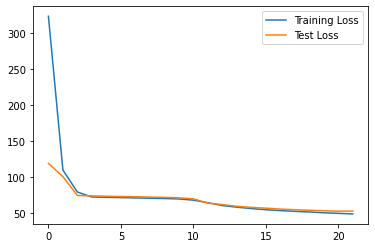

LOSS of the network on the test images: 482 %
Mean of the network on the Indian images after epoch 21 is 53.60892995198568
LOSS of the network on the test images: 521 %
Mean of the network on the Western images after epoch 21 is 57.93478139241537


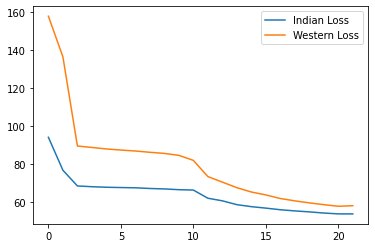

[23,     1] loss: 46.319
[23,     2] loss: 48.703
[23,     3] loss: 43.928
[23,     4] loss: 45.836
[23,     5] loss: 49.396
[23,     6] loss: 47.842
[23,     7] loss: 49.222
[23,     8] loss: 45.580
[23,     9] loss: 45.244
[23,    10] loss: 45.144
[23,    11] loss: 49.366
[23,    12] loss: 48.261
[23,    13] loss: 48.170
[23,    14] loss: 48.085
[23,    15] loss: 47.405
[23,    16] loss: 46.740
[23,    17] loss: 49.594
[23,    18] loss: 43.609
[23,    19] loss: 50.333
[23,    20] loss: 51.948
[23,    21] loss: 46.199
[23,    22] loss: 49.422
[23,    23] loss: 50.366
[23,    24] loss: 49.100
[23,    25] loss: 45.477
[23,    26] loss: 49.484
[23,    27] loss: 48.994
[23,    28] loss: 47.479
[23,    29] loss: 50.559
[23,    30] loss: 41.463
[23,    31] loss: 49.415
[23,    32] loss: 43.842
[23,    33] loss: 45.073
[23,    34] loss: 45.320
[23,    35] loss: 45.477
[23,    36] loss: 44.733
[23,    37] loss: 47.688
[23,    38] loss: 49.689
[23,    39] loss: 47.338
[23,    40] loss: 47.031


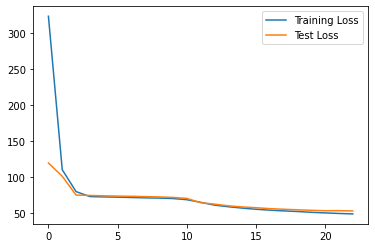

LOSS of the network on the test images: 479 %
Mean of the network on the Indian images after epoch 22 is 53.26828087700738
LOSS of the network on the test images: 515 %
Mean of the network on the Western images after epoch 22 is 57.313362545437286


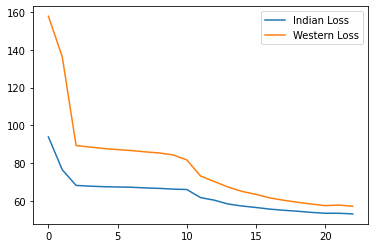

[24,     1] loss: 45.678
[24,     2] loss: 48.375
[24,     3] loss: 44.069
[24,     4] loss: 45.649
[24,     5] loss: 48.835
[24,     6] loss: 46.894
[24,     7] loss: 48.758
[24,     8] loss: 44.553
[24,     9] loss: 44.426
[24,    10] loss: 44.530
[24,    11] loss: 48.700
[24,    12] loss: 47.737
[24,    13] loss: 47.172
[24,    14] loss: 47.035
[24,    15] loss: 46.544
[24,    16] loss: 45.882
[24,    17] loss: 48.301
[24,    18] loss: 43.021
[24,    19] loss: 49.099
[24,    20] loss: 51.068
[24,    21] loss: 45.518
[24,    22] loss: 48.488
[24,    23] loss: 50.024
[24,    24] loss: 48.002
[24,    25] loss: 44.435
[24,    26] loss: 49.025
[24,    27] loss: 47.576
[24,    28] loss: 47.912
[24,    29] loss: 48.875
[24,    30] loss: 41.331
[24,    31] loss: 48.111
[24,    32] loss: 42.895
[24,    33] loss: 44.787
[24,    34] loss: 43.212
[24,    35] loss: 45.651
[24,    36] loss: 43.744
[24,    37] loss: 47.401
[24,    38] loss: 47.789
[24,    39] loss: 47.578
[24,    40] loss: 45.374


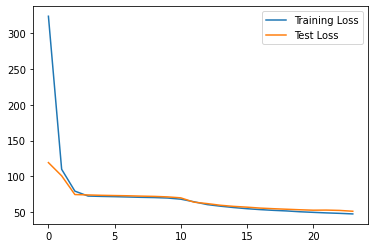

LOSS of the network on the test images: 473 %
Mean of the network on the Indian images after epoch 23 is 52.592503017849396
LOSS of the network on the test images: 500 %
Mean of the network on the Western images after epoch 23 is 55.57406107584635


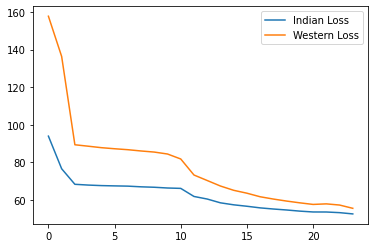

[25,     1] loss: 44.892
[25,     2] loss: 47.589
[25,     3] loss: 41.859
[25,     4] loss: 44.863
[25,     5] loss: 47.127
[25,     6] loss: 46.073
[25,     7] loss: 47.260
[25,     8] loss: 43.555
[25,     9] loss: 43.577
[25,    10] loss: 43.522
[25,    11] loss: 47.288
[25,    12] loss: 46.647
[25,    13] loss: 45.999
[25,    14] loss: 46.336
[25,    15] loss: 45.254
[25,    16] loss: 45.100
[25,    17] loss: 47.746
[25,    18] loss: 42.286
[25,    19] loss: 48.211
[25,    20] loss: 50.299
[25,    21] loss: 44.481
[25,    22] loss: 47.602
[25,    23] loss: 48.736
[25,    24] loss: 46.327
[25,    25] loss: 43.653
[25,    26] loss: 47.333
[25,    27] loss: 46.783
[25,    28] loss: 45.997
[25,    29] loss: 47.342
[25,    30] loss: 40.256
[25,    31] loss: 46.732
[25,    32] loss: 42.282
[25,    33] loss: 43.317
[25,    34] loss: 42.676
[25,    35] loss: 44.104
[25,    36] loss: 42.878
[25,    37] loss: 46.062
[25,    38] loss: 46.733
[25,    39] loss: 46.013
[25,    40] loss: 44.423


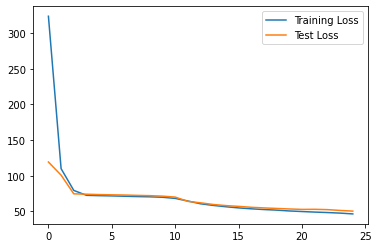

LOSS of the network on the test images: 465 %
Mean of the network on the Indian images after epoch 24 is 51.70560285780165
LOSS of the network on the test images: 490 %
Mean of the network on the Western images after epoch 24 is 54.48026996188693


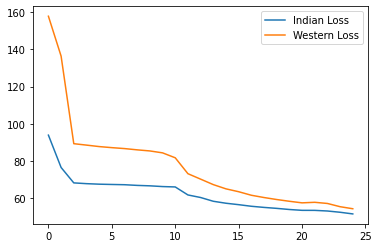

[26,     1] loss: 43.776
[26,     2] loss: 46.300
[26,     3] loss: 41.275
[26,     4] loss: 43.636
[26,     5] loss: 46.449
[26,     6] loss: 44.665
[26,     7] loss: 46.402
[26,     8] loss: 42.392
[26,     9] loss: 42.722
[26,    10] loss: 42.811
[26,    11] loss: 46.266
[26,    12] loss: 46.082
[26,    13] loss: 45.174
[26,    14] loss: 45.670
[26,    15] loss: 44.416
[26,    16] loss: 44.331
[26,    17] loss: 46.643
[26,    18] loss: 41.800
[26,    19] loss: 47.399
[26,    20] loss: 49.460
[26,    21] loss: 43.835
[26,    22] loss: 46.856
[26,    23] loss: 47.960
[26,    24] loss: 45.805
[26,    25] loss: 42.753
[26,    26] loss: 46.777
[26,    27] loss: 46.019
[26,    28] loss: 45.325
[26,    29] loss: 46.712
[26,    30] loss: 39.553
[26,    31] loss: 46.136
[26,    32] loss: 41.741
[26,    33] loss: 42.774
[26,    34] loss: 42.278
[26,    35] loss: 43.195
[26,    36] loss: 42.416
[26,    37] loss: 45.350
[26,    38] loss: 46.205
[26,    39] loss: 45.189
[26,    40] loss: 44.029


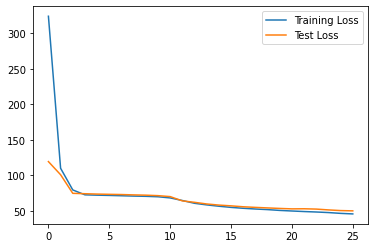

LOSS of the network on the test images: 461 %
Mean of the network on the Indian images after epoch 25 is 51.32701110839844
LOSS of the network on the test images: 486 %
Mean of the network on the Western images after epoch 25 is 54.044923570421005


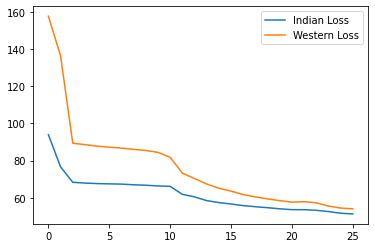

[27,     1] loss: 43.190
[27,     2] loss: 45.330
[27,     3] loss: 40.810
[27,     4] loss: 42.812
[27,     5] loss: 45.932
[27,     6] loss: 43.891
[27,     7] loss: 45.570
[27,     8] loss: 41.580
[27,     9] loss: 42.068
[27,    10] loss: 42.283
[27,    11] loss: 45.526
[27,    12] loss: 45.321
[27,    13] loss: 44.454
[27,    14] loss: 45.060
[27,    15] loss: 43.742
[27,    16] loss: 43.662
[27,    17] loss: 45.595
[27,    18] loss: 41.126
[27,    19] loss: 46.651
[27,    20] loss: 48.935
[27,    21] loss: 43.040
[27,    22] loss: 46.449
[27,    23] loss: 47.087
[27,    24] loss: 45.431
[27,    25] loss: 42.331
[27,    26] loss: 45.950
[27,    27] loss: 45.699
[27,    28] loss: 44.353
[27,    29] loss: 46.159
[27,    30] loss: 39.301
[27,    31] loss: 45.321
[27,    32] loss: 41.501
[27,    33] loss: 42.155
[27,    34] loss: 41.946
[27,    35] loss: 42.663
[27,    36] loss: 41.927
[27,    37] loss: 44.800
[27,    38] loss: 45.499
[27,    39] loss: 44.610
[27,    40] loss: 43.394


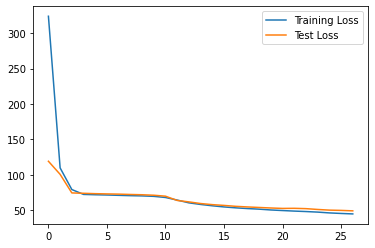

LOSS of the network on the test images: 457 %
Mean of the network on the Indian images after epoch 26 is 50.860335456000435
LOSS of the network on the test images: 478 %
Mean of the network on the Western images after epoch 26 is 53.20158216688368


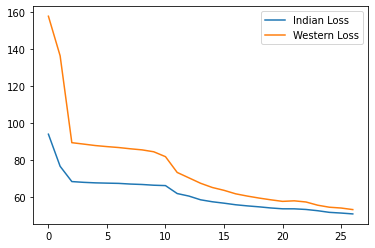

[28,     1] loss: 42.574
[28,     2] loss: 44.721
[28,     3] loss: 40.118
[28,     4] loss: 42.314
[28,     5] loss: 45.031
[28,     6] loss: 43.223
[28,     7] loss: 44.805
[28,     8] loss: 40.951
[28,     9] loss: 41.448
[28,    10] loss: 41.759
[28,    11] loss: 44.819
[28,    12] loss: 44.716
[28,    13] loss: 43.684
[28,    14] loss: 44.099
[28,    15] loss: 43.086
[28,    16] loss: 42.963
[28,    17] loss: 44.820
[28,    18] loss: 40.614
[28,    19] loss: 46.024
[28,    20] loss: 48.104
[28,    21] loss: 42.443
[28,    22] loss: 45.681
[28,    23] loss: 46.376
[28,    24] loss: 44.807
[28,    25] loss: 41.605
[28,    26] loss: 45.311
[28,    27] loss: 45.013
[28,    28] loss: 43.735
[28,    29] loss: 45.271
[28,    30] loss: 38.828
[28,    31] loss: 44.631
[28,    32] loss: 40.953
[28,    33] loss: 41.642
[28,    34] loss: 41.208
[28,    35] loss: 42.130
[28,    36] loss: 41.444
[28,    37] loss: 44.258
[28,    38] loss: 44.837
[28,    39] loss: 44.005
[28,    40] loss: 42.877


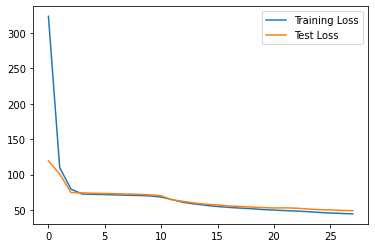

LOSS of the network on the test images: 454 %
Mean of the network on the Indian images after epoch 27 is 50.509575313991974
LOSS of the network on the test images: 474 %
Mean of the network on the Western images after epoch 27 is 52.69498952229818


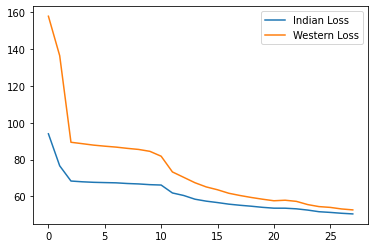

[29,     1] loss: 42.068
[29,     2] loss: 44.064
[29,     3] loss: 39.614
[29,     4] loss: 41.791
[29,     5] loss: 44.330
[29,     6] loss: 42.547
[29,     7] loss: 44.076
[29,     8] loss: 40.287
[29,     9] loss: 40.814
[29,    10] loss: 41.241
[29,    11] loss: 44.152
[29,    12] loss: 44.169
[29,    13] loss: 42.998
[29,    14] loss: 43.402
[29,    15] loss: 42.448
[29,    16] loss: 42.274
[29,    17] loss: 44.094
[29,    18] loss: 40.135
[29,    19] loss: 45.375
[29,    20] loss: 47.409
[29,    21] loss: 41.863
[29,    22] loss: 45.015
[29,    23] loss: 45.691
[29,    24] loss: 44.181
[29,    25] loss: 41.021
[29,    26] loss: 44.590
[29,    27] loss: 44.384
[29,    28] loss: 43.093
[29,    29] loss: 44.297
[29,    30] loss: 38.458
[29,    31] loss: 43.933
[29,    32] loss: 40.410
[29,    33] loss: 41.053
[29,    34] loss: 40.523
[29,    35] loss: 41.491
[29,    36] loss: 40.929
[29,    37] loss: 43.682
[29,    38] loss: 44.128
[29,    39] loss: 43.414
[29,    40] loss: 42.291


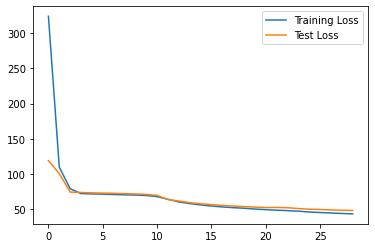

LOSS of the network on the test images: 451 %
Mean of the network on the Indian images after epoch 28 is 50.201256646050346
LOSS of the network on the test images: 470 %
Mean of the network on the Western images after epoch 28 is 52.309366861979164


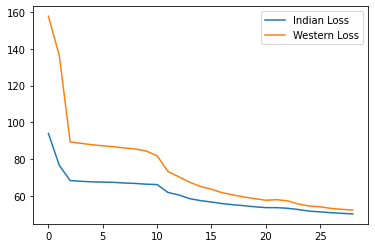

[30,     1] loss: 41.567
[30,     2] loss: 43.323
[30,     3] loss: 39.171
[30,     4] loss: 41.210
[30,     5] loss: 43.756
[30,     6] loss: 41.875
[30,     7] loss: 43.371
[30,     8] loss: 39.643
[30,     9] loss: 40.058
[30,    10] loss: 40.703
[30,    11] loss: 43.492
[30,    12] loss: 43.529
[30,    13] loss: 42.306
[30,    14] loss: 42.733
[30,    15] loss: 41.777
[30,    16] loss: 41.520
[30,    17] loss: 43.339
[30,    18] loss: 39.367
[30,    19] loss: 44.576
[30,    20] loss: 46.735
[30,    21] loss: 41.169
[30,    22] loss: 44.258
[30,    23] loss: 44.991
[30,    24] loss: 43.370
[30,    25] loss: 40.331
[30,    26] loss: 43.959
[30,    27] loss: 43.513
[30,    28] loss: 42.510
[30,    29] loss: 43.325
[30,    30] loss: 37.828
[30,    31] loss: 43.316
[30,    32] loss: 39.811
[30,    33] loss: 40.415
[30,    34] loss: 39.841
[30,    35] loss: 40.842
[30,    36] loss: 40.317
[30,    37] loss: 43.190
[30,    38] loss: 43.365
[30,    39] loss: 42.889
[30,    40] loss: 41.647


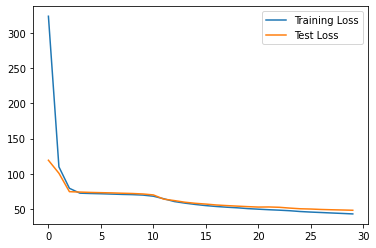

LOSS of the network on the test images: 448 %
Mean of the network on the Indian images after epoch 29 is 49.862333085801865
LOSS of the network on the test images: 466 %
Mean of the network on the Western images after epoch 29 is 51.836327446831596


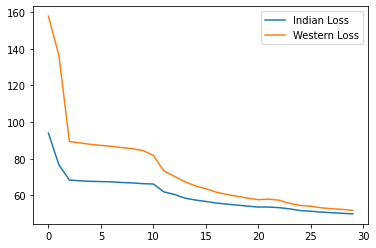

Finished Training


In [ ]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)


    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(indian_loader,0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Indian images after epoch {} is {}'.format(epoch, total_Loss) )

    indian_loss_graph.append(total_Loss)

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(western_loader,0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Western images after epoch {} is {}'.format(epoch, total_Loss) )

    western_loss_graph.append(total_Loss)

    visualize_class_loss(indian_loss_graph, western_loss_graph)
          

print('Finished Training')

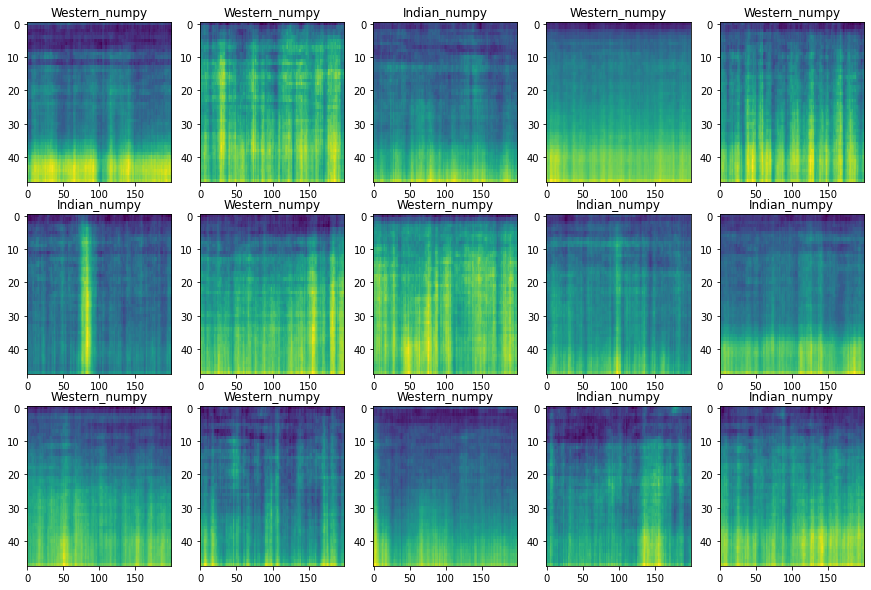

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

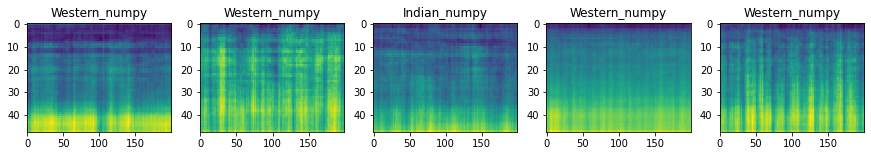

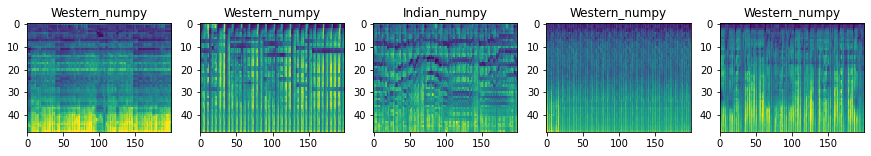

In [ ]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [ ]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [ ]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [ ]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(id_test) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(id_test) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(id_test) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(id_test) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(id_test) + ".npy"), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




In [ ]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(id_train) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(id_train) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(id_train) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(id_train) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(id_train) + ".npy"), np.transpose(orr48, (1,0)))
          id_train = id_train + 1